  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

DAILY
=== Begin running at 2021-06-02 15:50:07.903418 ====



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.98it/s]


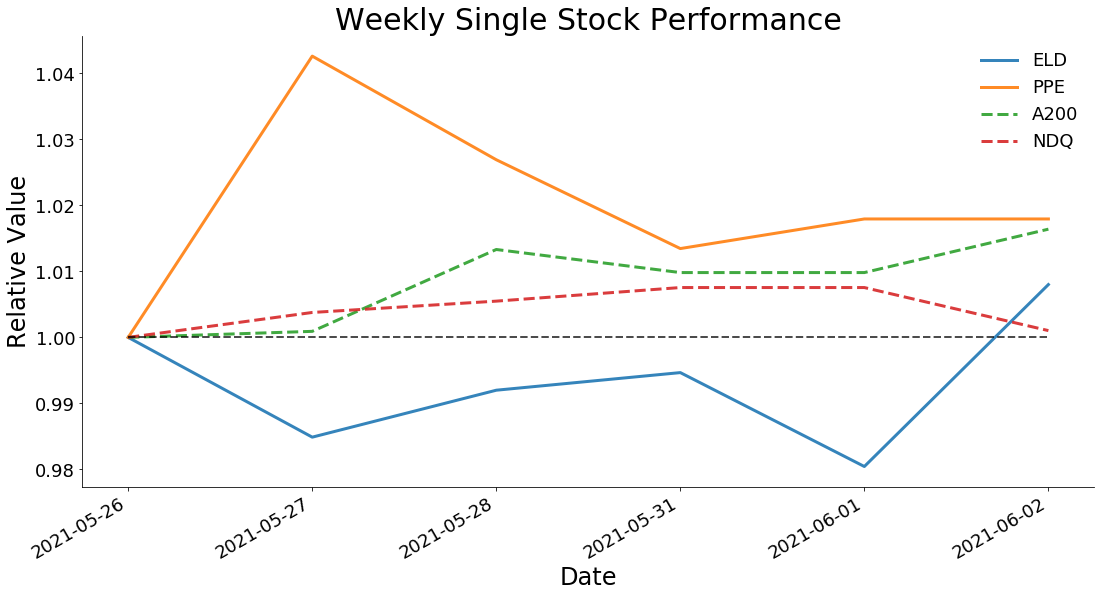

Email to    Cameron succeeded at 2021-06-02 15:50:15.146464

==== Completed emailing at 2021-06-02 15:50:20.149320 ====




In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from yahooquery import Ticker
from tqdm import tqdm
from siif_utils import send_email, attach_file, attach_image, log, TEST, PROD, SIIF, equidate_ax
import warnings
warnings.filterwarnings("ignore")
from time import sleep
import numpy as np

############## INPUT PARAMETERS ##############                     
RUNNING_LEVEL = TEST
##############################################

####################################### STEP 1. PREPARE DATA ########################################
log('begin', running_level=RUNNING_LEVEL, freq='DAILY')

TODAY = dt.date.today()
LAST_WEEK = TODAY - pd.Timedelta(days=7)

def load_data(codes, start=str(LAST_WEEK), end='3000-01-01', verbose=True):
    ''' Takes list of shares and returns data from the start date '''
    daily = pd.DataFrame({'date': []})
    codes = tqdm(codes) if verbose else codes

    # Load data
    for code in codes:
        df = Ticker(f'{code}.AX').history(start=start, end=end).reset_index()[['date', 'close']]
        df.columns = ['date', code]
        daily = pd.merge(daily, df, on='date', how='outer')

    daily['date'] = pd.to_datetime(daily.date)
    daily = daily.sort_values('date').ffill().set_index('date')
    return daily

TEST_NAME = 'Cameron'

# Load analyst emails
emails = pd.read_csv('./data/emails.csv')
ANALYSTS_TEST = emails[emails['name'] == TEST_NAME]
ANALYSTS_PROD = emails
ANALYSTS = ANALYSTS_PROD if RUNNING_LEVEL == PROD else ANALYSTS_TEST

######################################### STEP 2. PLOT DATA #########################################
SMALL, MED, LARGE, LW = 18, 24, 30, 2
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)   # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)         # controls default text sizes

def plot_shares(daily, filename, save=False, scale=1):
    ''' Plots each individual share's value for each share in composition '''
    fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
    
    x = np.arange(len(daily))
    for code in daily:
        ls = '--' if code in ['A200', 'NDQ'] else '-'
        ax.plot(x, daily[code] / daily[code].iloc[0], label=code, alpha=0.9, lw=1.5*LW, linestyle=ls)

    # Aesthetics
    ax.plot(x, np.ones(len(daily)), linestyle='--', lw=LW, c='black', alpha=0.7)
    sns.despine()
    ax.set_title('Weekly Single Stock Performance', fontsize=LARGE)
    ax.set_xlabel('Date')
    ax.set_ylabel('Relative Value')
    plt.legend(frameon=False, fontsize=SMALL)
    equidate_ax(fig, ax, daily.index)
    if save:
        plt.savefig('./images/'+filename+'.png', dpi=scale*2*fig.dpi)
    plt.show()
    
######################################## STEP 3. SEND EMAILS ########################################
import cgi
import uuid
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.header import Header

gmail_user = "sarasiifbot@gmail.com"
with open('./data/password.txt') as f:
    gmail_pwd = f.read()

LOGO_PATH = './images/SIIF Logo.png'
LOGO_SCALE = (258, 155)
GRAPH_SCALE = (691, 389)

def generate_email(gmail_user, to, daily_changes, img_dict, name='Analyst'):
    msg = MIMEMultipart('related')
    msg['Subject'] = Header(u'SIIF - Large Stock Movement Alert', 'utf-8')
    msg['From'] = gmail_user
    msg['To'] = to
    msg_alternative = MIMEMultipart('alternative')
    msg_text = MIMEText(u'Image not working', 'plain', 'utf-8')
    msg_alternative.attach(msg_text)
    msg.attach(msg_alternative)

    msg_html = u'<p>Dear {},</p>'.format(name)
    for code, change in daily_changes:
        msg_html += u"<p>Today {} {} {}%</p>".format(code, 'dropped' if change < 0 else 'rose', round(abs(change), 1))
    msg_html += u"<p>You may like to investigate why. "
    
    msg_html += u'<a href="https://www.google.com/search?q={}+asx">Click here to begin researching!</a></p>'.format(code)
    
    
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape('image not found', quote=True), w=GRAPH_SCALE[0], h=GRAPH_SCALE[1], **img_dict[0])
    
    # Add sign-off and logo
    msg_html += '<p>Have a great day!</p><p>From Sara (SIIF Automated Reporting Assistant)</p>'
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape('image not found', quote=True), w=LOGO_SCALE[0], h=LOGO_SCALE[1], **img_dict[-1])
    
    msg_html += u"<p>---------------------------------</p>"
    msg_html += u"<p><small>Do not reply to this email</small></p>"
    msg_html += u"<p><small>Code available at https://github.com/CameronChandler/SARA</small></p>"
    msg_html += u"<p><small>Disclaimer: This email is automated and the data/visualisations/calculations are subject to errors!</small></p>"
    msg_html += u"<p><small>This has not been checked by a human, so please do not use to inform your financial decisions.</small></p>"

    msg_html = MIMEText(msg_html, 'html', 'utf-8')
    msg_alternative.attach(msg_html)
    for img in img_dict:
        msg.attach(attach_image(img))

    return msg

for i, row in ANALYSTS.iterrows():
    name, email = row['name'], row['email']
    if RUNNING_LEVEL == TEST and name != TEST_NAME:
        continue

    if not row['stocks']:
        continue
        
    stocks = row['stocks'].split() + ['A200', 'NDQ']
    daily = load_data(stocks)
    
    # Ensure that the markets ran today
    if TODAY != daily.index[-1].date():
        continue
    
    daily_changes = []
    for code in daily:
        pct_change = 100 * (daily[code].iloc[-1] / daily[code].iloc[-2] - 1)
        if abs(pct_change) > float(row['sensitivity']):
            daily_changes.append([code, pct_change])
            
    if not daily_changes:
        continue
        
    filename = 'daily'
    plot_shares(daily, filename, save=True)
    
    img_dict = []
    all_files = [(f'./images/{filename}.png', GRAPH_SCALE), (LOGO_PATH, LOGO_SCALE)]

    for file, scale in all_files:
        img_dict_single = dict(title=file, path=file, cid=str(uuid.uuid4()), scale=scale)
        img_dict.append(img_dict_single)

    #try:
    email_msg = generate_email(gmail_user, email, daily_changes, img_dict=img_dict, name=name)
    send_email(email_msg, gmail_user, gmail_pwd, email)
    log('success', name=name, running_level=RUNNING_LEVEL)
    #except:
    #    log('failure', name=name, running_level=RUNNING_LEVEL)
    
    sleep(5)
        
log('end', running_level=RUNNING_LEVEL)